In [3]:
!unrar x "/content/PlantVillage.rar"

#In potato plant dataset we have 3 classes

**'Potato___Early_blight'**

**'Potato___Late_blight'**

**'Potato___healthy'**

In [49]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [50]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50


In [51]:
# loading dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "/content/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [52]:
#classes name
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [53]:
#lenght of dataset
len(dataset)

68

In [54]:
#lets explore 1 batch data
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 1 2 2 1 1 0 1 1 1 1 0 1 1 1 1 1 0 2 0 1 1 1 0 0 0 0 1 1 1 0]


In [55]:
#lets explore 1 image data
for image_batch,label_batch in dataset.take(1):
  print(image_batch[0])

tf.Tensor(
[[[ 92.  87.  94.]
  [ 86.  81.  88.]
  [ 86.  81.  88.]
  ...
  [145. 140. 147.]
  [143. 138. 145.]
  [142. 137. 144.]]

 [[ 94.  89.  96.]
  [ 89.  84.  91.]
  [ 88.  83.  90.]
  ...
  [148. 143. 150.]
  [147. 142. 149.]
  [147. 142. 149.]]

 [[ 96.  91.  98.]
  [ 93.  88.  95.]
  [ 91.  86.  93.]
  ...
  [146. 141. 148.]
  [146. 141. 148.]
  [147. 142. 149.]]

 ...

 [[132. 127. 134.]
  [128. 123. 130.]
  [132. 127. 134.]
  ...
  [151. 148. 157.]
  [149. 146. 155.]
  [147. 144. 153.]]

 [[127. 122. 129.]
  [125. 120. 127.]
  [134. 129. 136.]
  ...
  [152. 149. 158.]
  [150. 147. 156.]
  [149. 146. 155.]]

 [[133. 128. 135.]
  [137. 132. 139.]
  [155. 150. 157.]
  ...
  [149. 146. 155.]
  [153. 150. 159.]
  [156. 153. 162.]]], shape=(256, 256, 3), dtype=float32)


In [11]:
#lets explore 1 image data in numpy
for image_batch,label_batch in dataset.take(1):
  print(image_batch[0].shape)

(256, 256, 3)


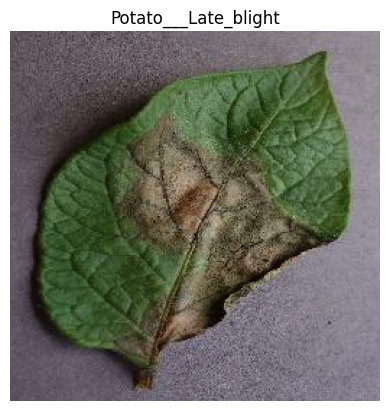

In [12]:
#lets show image and its label
for image_batch,label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(class_names[label_batch[0]])
  plt.axis("off")

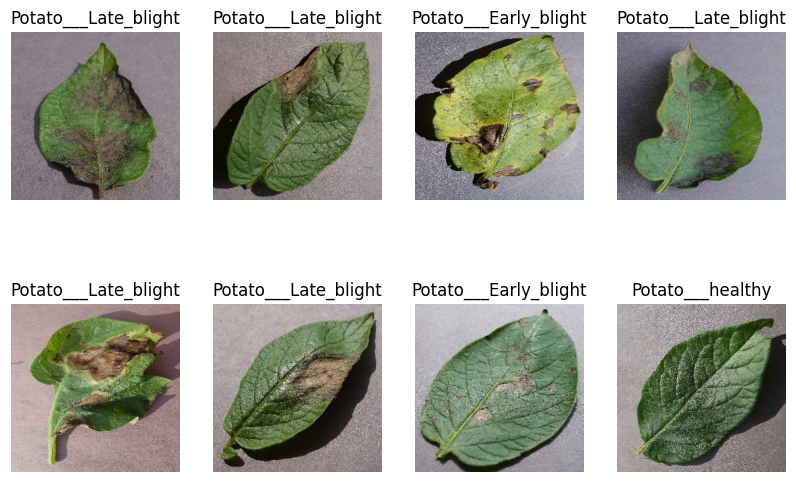

In [13]:
#lets shows some images and its labels
plt.figure(figsize =(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

# **Spliting dataset**

In [14]:
len(dataset)

68

In [15]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds = dataset.take(54)
len(train_ds)

54

In [17]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [18]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [19]:
val_ds = test_ds.take(6)
len(val_ds)


6

In [20]:

test_ds = test_ds.skip(6)
len(test_ds)

8

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [23]:
len(train_ds)


54

In [24]:
len(val_ds)


6

In [25]:
len(test_ds)


8

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Building a model**

In [27]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# **Data Augmentation**


In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [30]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [33]:
#compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 32s 422ms/step - loss: 0.9220 - accuracy: 0.5260 - val_loss: 0.8665 - val_accuracy: 0.5208
Epoch 2/50
54/54 [==============================] - 22s 404ms/step - loss: 0.6451 - accuracy: 0.7234 - val_loss: 1.0455 - val_accuracy: 0.5833
Epoch 3/50
54/54 [==============================] - 22s 397ms/step - loss: 0.5215 - accuracy: 0.7749 - val_loss: 0.4798 - val_accuracy: 0.8073
Epoch 4/50
54/54 [==============================] - 21s 393ms/step - loss: 0.3952 - accuracy: 0.8403 - val_loss: 0.4669 - val_accuracy: 0.7083
Epoch 5/50
54/54 [==============================] - 21s 387ms/step - loss: 0.3802 - accuracy: 0.8519 - val_loss: 0.4454 - val_accuracy: 0.8177
Epoch 6/50
54/54 [==============================] - 22s 399ms/step - loss: 0.3374 - accuracy: 0.8628 - val_loss: 0.3576 - val_accuracy: 0.8229
Epoch 7/50
54/54 [==============================] - 22s 397ms/step - loss: 0.3065 - accuracy: 0.8709 - val_loss: 0.2048 - val_accuracy: 0.9271

In [35]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 4s 28ms/step - loss: 0.0242 - accuracy: 0.9883


In [36]:
#score is a list that contain loss and accuracy
scores

[0.024233663454651833, 0.98828125]

In [40]:
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score

def get_predictions(model, dataset):
    predictions = []
    true_labels = []

    for batch_data, batch_labels in dataset:
        batch_predictions = model.predict(batch_data)
        predictions.extend(tf.math.argmax(batch_predictions, axis=1).numpy())
        true_labels.extend(tf.math.argmax(batch_labels, axis=1).numpy())

    return true_labels, predictions

dataset_path = "/content/PlantVillage"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_true_labels, val_predictions = get_predictions(model, dataset)

print("Classification Report on Validation Data:")
print(classification_report(val_true_labels, val_predictions))

accuracy = accuracy_score(val_true_labels, val_predictions)
print(f"Accuracy on Validation Data: {accuracy}")


Found 2152 files belonging to 3 classes.
1/1 [==============================] - 1s 545ms/step
Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1000
           1       1.00      0.98      0.99      1000
           2       0.99      0.99      0.99       152

    accuracy                           0.99      2152
   macro avg       0.99      0.99      0.99      2152
weighted avg       0.99      0.99      0.99      2152

Accuracy on Validation Data: 0.9907063197026023


# **lets try another data of tomato plants that have four class**

In [3]:
# !unrar x "/content/PlantVillage2.rar"

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 50


In [3]:
# loading dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "C:\\Users\\nnsir\\OneDrive\\Desktop\\plant disease\\PlantVillage2",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 6627 files belonging to 4 classes.


In [4]:
#classes name
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

In [5]:
#lets explore 1 image data
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])


tf.Tensor(
[[[159. 150. 153.]
  [136. 127. 130.]
  [145. 136. 139.]
  ...
  [143. 134. 137.]
  [144. 135. 138.]
  [144. 135. 138.]]

 [[149. 140. 143.]
  [137. 128. 131.]
  [154. 145. 148.]
  ...
  [143. 134. 137.]
  [148. 139. 142.]
  [153. 144. 147.]]

 [[148. 139. 142.]
  [139. 130. 133.]
  [149. 140. 143.]
  ...
  [142. 133. 136.]
  [149. 140. 143.]
  [157. 148. 151.]]

 ...

 [[141. 129. 133.]
  [141. 129. 133.]
  [126. 114. 118.]
  ...
  [112. 101. 105.]
  [110.  99. 103.]
  [111. 100. 104.]]

 [[123. 111. 115.]
  [131. 119. 123.]
  [116. 104. 108.]
  ...
  [119. 108. 112.]
  [113. 102. 106.]
  [108.  97. 101.]]

 [[124. 112. 116.]
  [136. 124. 128.]
  [121. 109. 113.]
  ...
  [113. 102. 106.]
  [122. 111. 115.]
  [133. 122. 126.]]], shape=(256, 256, 3), dtype=float32)


In [6]:
#lets explore 1 batch data
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())



(64, 256, 256, 3)
[1 1 0 0 2 0 1 2 0 3 2 1 3 0 2 0 1 3 2 2 0 1 3 0 1 1 0 2 1 2 0 1 0 0 2 2 0
 2 0 0 1 1 1 0 0 0 2 0 3 3 0 0 0 0 2 0 3 3 0 0 2 2 1 3]


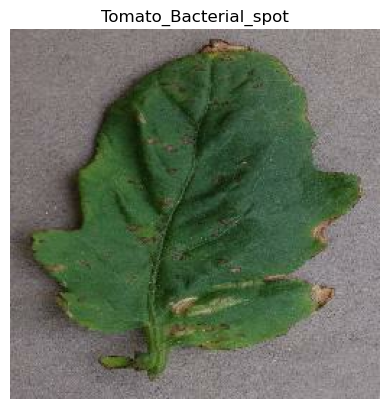

In [7]:
#lets show image and its label
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")


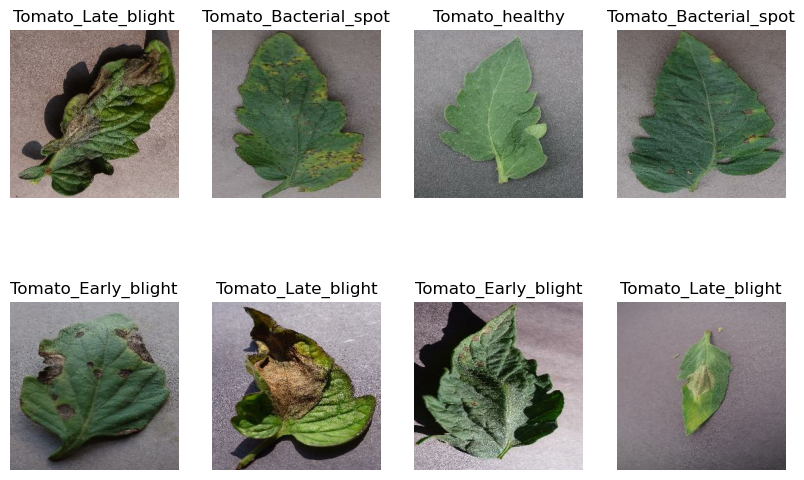

In [8]:

#lets shows some images and its labels
plt.figure(figsize =(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Splitting Dataset


In [9]:
len(dataset)

104

In [10]:
train_size = 0.8
len(dataset)*train_size


83.2

In [11]:
train_ds = dataset.take(83)
len(train_ds)

83

In [12]:
test_ds = dataset.skip(83)
len(test_ds)


21

In [13]:
val_size=0.1
len(dataset)*val_size

10.4

In [14]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [15]:
test_ds = test_ds.skip(10)
len(test_ds)

11

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [18]:
len(train_ds)


83

In [19]:
len(val_ds)


10

In [20]:
len(test_ds)


11

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Building a model**

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


# **Data Augmentations**

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [24]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4


In [26]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (64, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)         

In [28]:
#compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)


Epoch 1/10
83/83 [==============================] - 398s 5s/step - loss: 0.4169 - accuracy: 0.8346 - val_loss: 0.6766 - val_accuracy: 0.7250
Epoch 2/10
83/83 [==============================] - 394s 5s/step - loss: 0.3435 - accuracy: 0.8647 - val_loss: 0.6045 - val_accuracy: 0.7672
Epoch 3/10
83/83 [==============================] - 410s 5s/step - loss: 0.3988 - accuracy: 0.8429 - val_loss: 0.9622 - val_accuracy: 0.6547
Epoch 4/10
83/83 [==============================] - 394s 5s/step - loss: 0.4421 - accuracy: 0.8315 - val_loss: 0.4726 - val_accuracy: 0.8047
Epoch 5/10
83/83 [==============================] - 401s 5s/step - loss: 0.3196 - accuracy: 0.8779 - val_loss: 0.3815 - val_accuracy: 0.8406
Epoch 6/10
83/83 [==============================] - 389s 5s/step - loss: 0.2814 - accuracy: 0.8904 - val_loss: 0.5165 - val_accuracy: 0.8094
Epoch 7/10
83/83 [==============================] - 389s 5s/step - loss: 0.3113 - accuracy: 0.8804 - val_loss: 0.4149 - val_accuracy: 0.8500
Epoch 8/10
83

In [31]:
# Save the entire model with the specified name
model.save("plant_disease_classifier")


INFO:tensorflow:Assets written to: plant_disease_classifier\assets


INFO:tensorflow:Assets written to: plant_disease_classifier\assets


In [32]:
# Save only the model weights with the specified name
model.save_weights("plant_disease_classifier_weights.h5")
